In [1]:
import pandas as pd
import itertools
import collections
import numpy as np
from tqdm import tqdm
import gensim
import re
import json
import sklearn
import matplotlib.pyplot as plt

In [2]:
# This file is the output from the Issues_expand_wildcards.ipynb notebook
filename_issues = '/home/dafne/shared/FilterBubble/issue-positions/queries-asterix-expanded.csv'
filename_fasttext = '/home/dafne/shared/FilterBubble/word-embeddings/fasttext-aem-amcat50.bin'

In [3]:
# Load issues
df_issues = pd.read_csv(filename_issues)

In [4]:
# Load model
model = gensim.models.fasttext.load_facebook_model(filename_fasttext)

# If model file contains the raw word vectors, use:
# model = gensim.models.KeyedVectors.load_word2vec_format(filename_fasttext)

## Cross validation
For each topic, do a cross validation and calculate prec and rec plots

In [5]:
issue_list = df_issues['issue'].unique()

In [6]:
def get_f_score(prec, rec, beta=1):
    nom = (1+beta*beta)*prec*rec
    den = beta*beta*prec + rec
    if den == 0:
        den = 1
    return nom/den

def get_prec_recs(nearest_neighbors, test_words):
    """
    Calculates precision and recall for each top-n nearest neighbors
    """
    precisions = []
    recall = []
    f4 = []
    nr_true_positives = 0
    for i, (word, score) in enumerate(nearest_neighbors):
        if word in test_words:
            nr_true_positives += 1
        p = nr_true_positives / (i+1)
        r = nr_true_positives / len(test_words)
        precisions.append(p)
        recall.append(r)
        f4.append(get_f_score(p,r,4))
    prec_rec_df = pd.DataFrame({'precision': precisions, 'recall': recall, 'f4': f4})
    return prec_rec_df

In [7]:
def split_query_words(query_words, split_ratio=0.5):
    """
    Split the query words in a 'seed set' and a test/validation set
    """
    all_query_words = np.array(query_words)
    np.random.shuffle(all_query_words)

    nr_seeds = int(np.ceil(split_ratio * len(all_query_words)))
    seed_words = all_query_words[:nr_seeds]
    test_words = all_query_words[nr_seeds:]
    return seed_words, test_words

Now we calculate the precisions and recall with cross validation, so we make 10 different splits between seed and test words. We plot the average values over all splits.
The split is done half-half. This is a balance between on the one hand having enough seed sets to get a realistic performance, on the other hand having enough test words so that we can plot a proper precision and recall graph.

We also plot the average f4 score, this puts much more importance on the recall than on precision, and could be used as one measure to decide on the threshold.

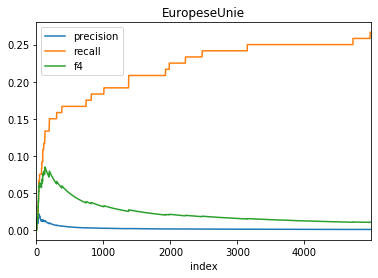

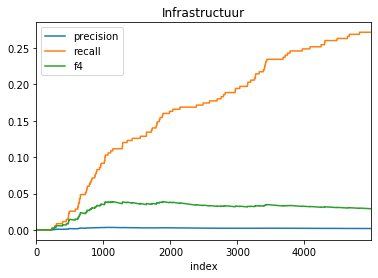

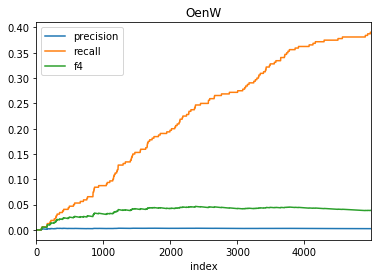

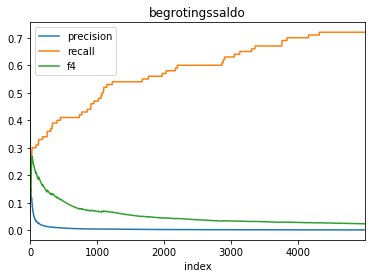

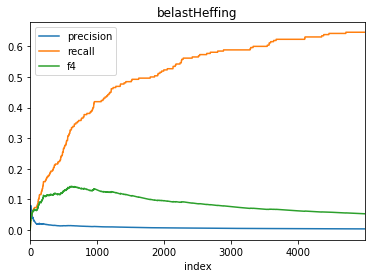

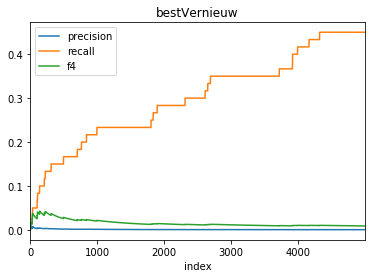

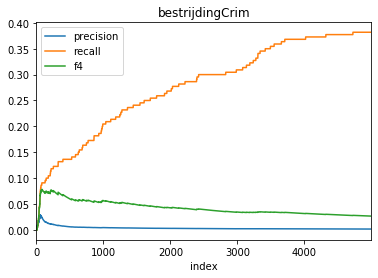

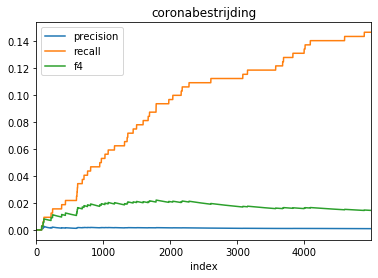

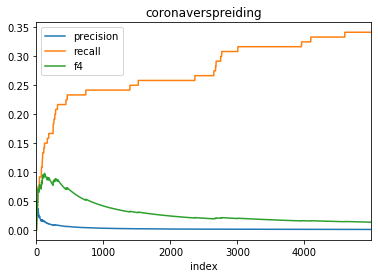

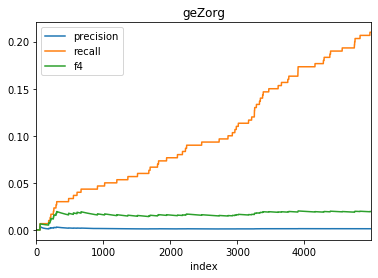

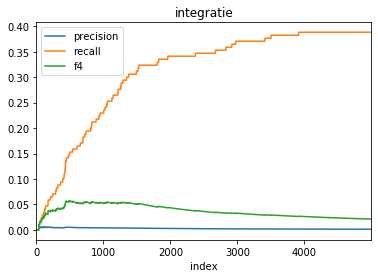

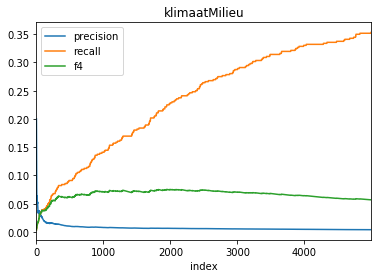

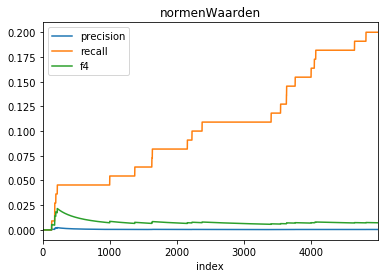

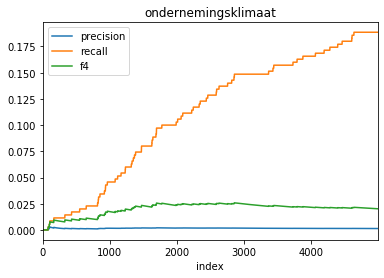

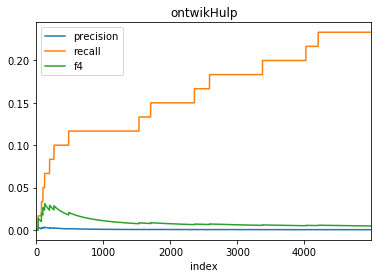

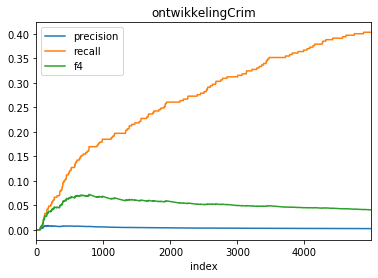

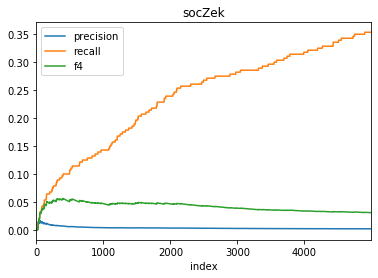

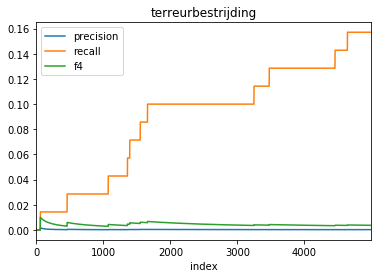

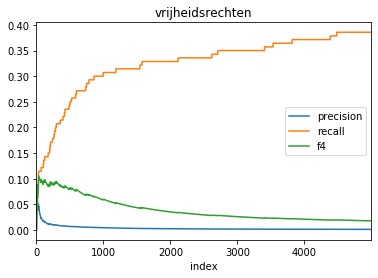

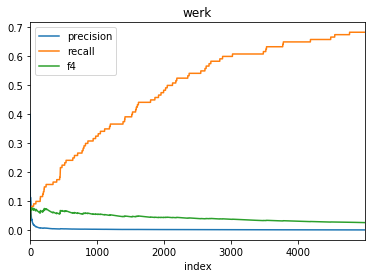

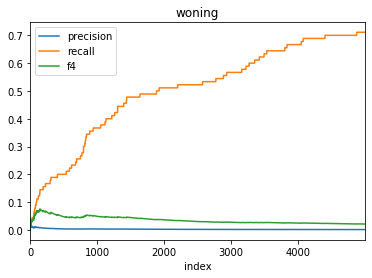

In [9]:
cv_iterations = 10
split_ratio = 0.5 # What fraction of the query terms do we take as seed

for issue in issue_list:
    df_list = []
    df_issues_sub = df_issues[(df_issues.issue == issue) & (df_issues.category!='expanded')]
    queries = [row['query'].replace('*', '') for _, row in df_issues_sub.iterrows()]
    for i in range(cv_iterations):
        # Split randomly in half: one pat for seeds, one part for testing
        seed_words, test_words = split_query_words(queries, split_ratio=split_ratio)
        nearest_neighbors = model.wv.most_similar(seed_words, topn=5000)#len(test_words)*10)
        prec_rec_df = get_prec_recs(nearest_neighbors, test_words)
        prec_rec_df = prec_rec_df.reset_index()
        prec_rec_df['cv'] = i
        df_list.append(prec_rec_df)
    prec_rec_df = pd.concat(df_list)
    prec_rec_df_means = prec_rec_df.groupby('index')[['precision', 'recall', 'f4']].mean()
    plot = prec_rec_df_means.plot()
    plot.set_title(issue)
    plt.show()

## Leave-one-out
We can also take all queries except one as seed set, and see where the one-out can be found.
We plot it as recall and precision, although this is not slightly correct: it is for each threshold value: how many of the query words would be found if they are held out of the seed set.

We compare the recall with the maximum possible recall: the percentage of all query words that are known to the vocabulary

In [83]:
def plot_prec_rec(ranks):
    rank_counts = pd.Series(ranks).value_counts(sort=False).sort_index()
    prec = []
    rec = []
    f4 = []
    indices = []
    total =  rank_counts.sum()
    cum_count = 0
    for idx, count in rank_counts[1:].iteritems():
        cum_count += count
        prec.append(cum_count / (idx+1))
        rec.append(cum_count / total)
        f4.append(get_f_score(prec[-1],rec[-1],4))
        indices.append(idx)
    return pd.DataFrame({'prec':prec, 'rec':rec, 'f4':f4}, index=indices)

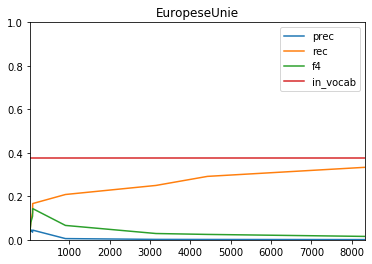

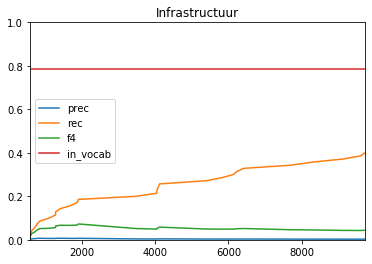

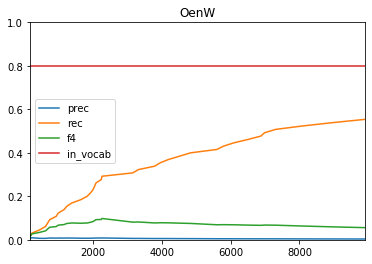

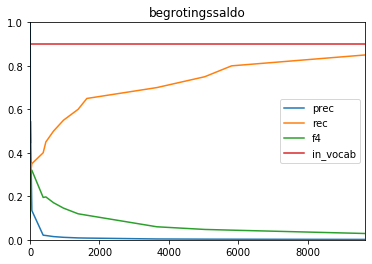

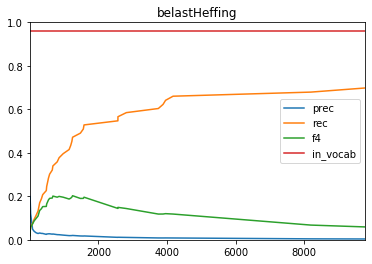

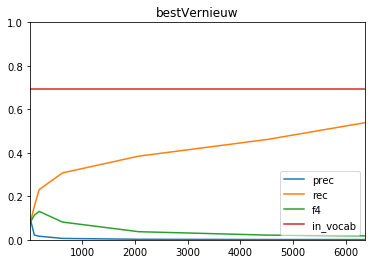

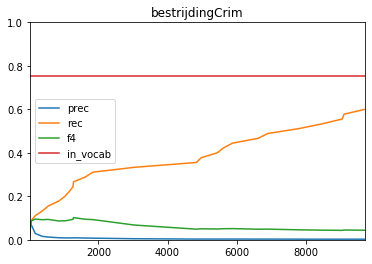

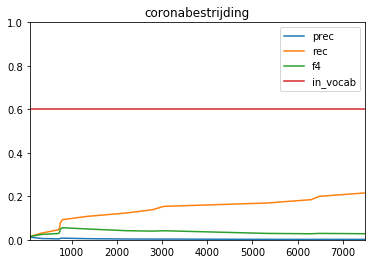

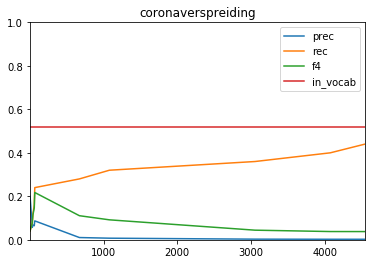

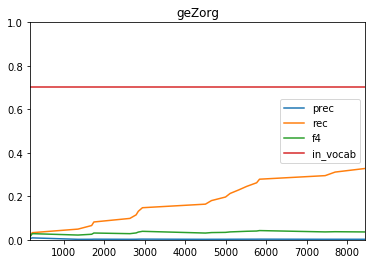

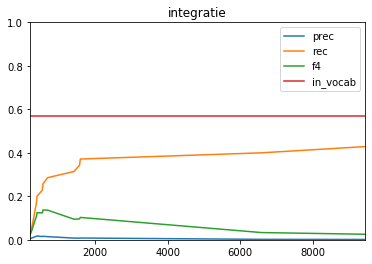

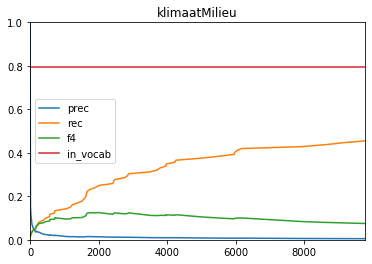

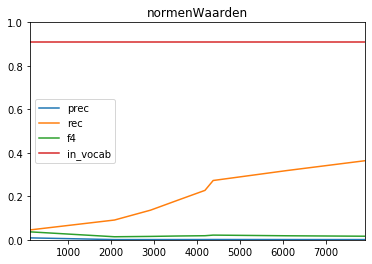

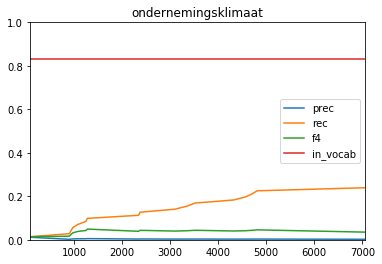

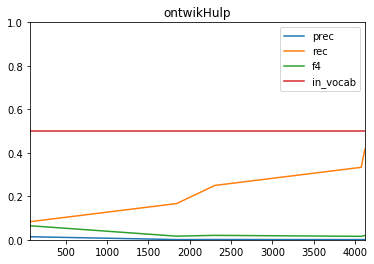

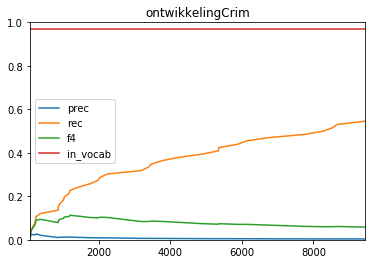

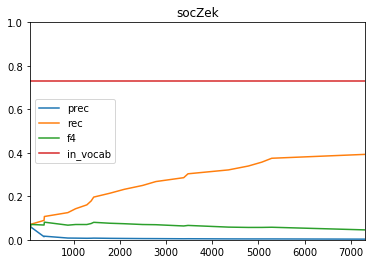

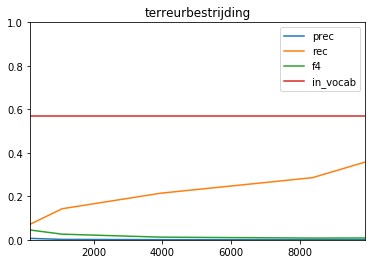

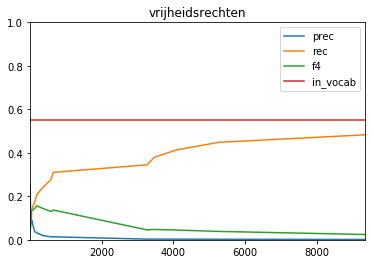

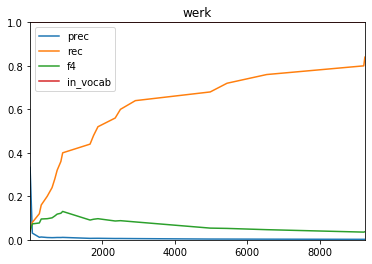

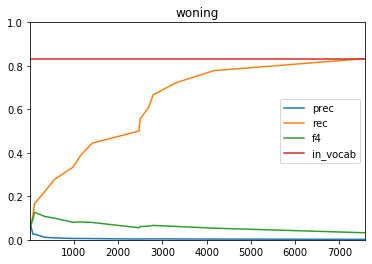

In [84]:
for issue in issue_list:
    df_issues_sub = df_issues[(df_issues.issue == issue) & (df_issues.category!='expanded')]
    queries = [row['query'].replace('*', '') for _, row in df_issues_sub.iterrows()]
    
    ranks = []
    for i in range(len(queries)):
        seed_set = queries[:i]+queries[i+1:]
        test_word = queries[i]
        nearest_neighbors = np.array([w for w,_ in model.wv.most_similar(seed_set, topn=10000)])
        rank = np.where(nearest_neighbors==test_word)[0]
        if len(rank) == 0:
            ranks.append(-1)
        else:
            ranks.append(rank[0])
    df = plot_prec_rec(ranks)
    df['in_vocab'] = df_issues_sub.vocab.mean()
    plot = df.plot()
    plot.set_title(issue)
    plt.ylim(0,1)
    plt.show()